Empty DataFrame
Columns: [TotalBoxes, CarriedBoxes, Grid]
Index: []


IndexError: single positional indexer is out-of-bounds

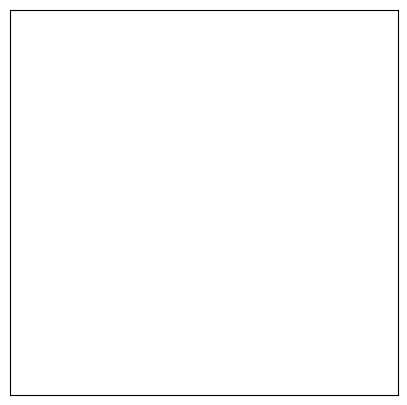

In [7]:
from mesa import Agent, Model
from mesa.space import MultiGrid
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.animation as animation

random.seed(67890)


class BoxAgent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.box_carried = False

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, moore=True, include_center=False)
        if not self.box_carried:
            possible_steps = [
                pos for pos in possible_steps if self.model.is_box(pos)] or possible_steps
        elif self.box_carried:
            possible_steps = [
                pos for pos in possible_steps if self.model.boxes[pos[0]][pos[1]] < 5] or possible_steps
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def step(self):
        if not self.box_carried and self.model.is_box(self.pos):
            self.box_carried = True
            self.model.pick_box(self.pos)
        elif self.box_carried and self.model.boxes[self.pos[0]][self.pos[1]] < 5:
            self.box_carried = False
            self.model.place_box(self.pos)
        self.move()


class WarehouseModel(Model):
    def __init__(self, width, height, num_agents, num_boxes):
        self.num_agents = num_agents
        self.num_boxes = num_boxes
        self.grid = MultiGrid(width, height, torus=False)
        self.schedule = RandomActivation(self)
        self.boxes = np.zeros((width, height))

        for i in range(self.num_agents):
            a = BoxAgent(i, self)
            self.schedule.add(a)
            pos = self.random_position()
            while self.is_box(pos):
                pos = self.random_position()
            self.grid.place_agent(a, pos)

        self.place_boxes(num_boxes)

        self.datacollector = DataCollector(
            model_reporters={"TotalBoxes": self.count_boxes,
                             "CarriedBoxes": self.count_carried_boxes, "Grid": self.get_grid}
        )

    def place_boxes(self, num_boxes):
        for _ in range(num_boxes):
            pos = self.random_position()
            self.boxes[pos[0]][pos[1]] += random.randint(1, 3)

    def is_box(self, pos):
        return self.boxes[pos[0]][pos[1]] > 0

    def pick_box(self, pos):
        if self.is_box(pos):
            self.boxes[pos[0]][pos[1]] -= 1

    def place_box(self, pos):
        self.boxes[pos[0]][pos[1]] += 1

    def count_boxes(self):
        return np.sum(self.boxes)

    def count_carried_boxes(self):
        return sum(agent.box_carried for agent in self.schedule.agents)

    def random_position(self):
        x = random.randint(0, self.grid.width - 1)
        y = random.randint(0, self.grid.height - 1)
        return (x, y)

    def is_simulation_done(self):
        return self.count_carried_boxes() == 0 and self.count_boxes() % 5 == 0

    def get_grid(self):
        return self.boxes.copy()

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()


WIDTH = 20
HEIGHT = 20
NUM_AGENTS = 5
NUM_BOXES = 200

model = WarehouseModel(WIDTH, HEIGHT, NUM_AGENTS, NUM_BOXES)
while not model.is_simulation_done():
    model.step()

data = model.datacollector.get_model_vars_dataframe()
print(data)

all_grids = data["Grid"]
fig, axis = plt.subplots(figsize=(5, 5))
axis.set_xticks([])
axis.set_yticks([])
patch = plt.imshow(all_grids.iloc[0], cmap=plt.cm.binary)


def animate(frame):
    patch.set_data(all_grids.iloc[frame])


anim = animation.FuncAnimation(fig, animate, frames=len(all_grids))
plt.show()